<a href="https://colab.research.google.com/github/vzeizer/Statistical_Analysis_LifeExpectancy/blob/master/Projeto3_DSA_PySpark_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SQLAlchemy==1.4.46

In [ ]:
!pip install --upgrade pandasql

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

from pandasql import sqldf

df_pd=pd.read_csv('/content/drive/MyDrive/tfl_bus_safety.csv')

# EDA

## Visualizando o dataframe

In [ ]:
# olhando as cinco primeiras linhas
df_pd.head(5)

,year,date_of_incident,route,operator,group_name,bus_garage,borough,injury_result_description,incident_event_type,victim_category,victims_sex,victims_age
0,2015,2015-01-01,1,London General,Go-Ahead,Garage Not Available,Southwark,Injuries treated on scene,Onboard Injuries,Passenger,Male,Child
1,2015,2015-01-01,4,Metroline,Metroline,Garage Not Available,Islington,Injuries treated on scene,Onboard Injuries,Passenger,Male,Unknown
2,2015,2015-01-01,5,East London,Stagecoach,Garage Not Available,Havering,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
3,2015,2015-01-01,5,East London,Stagecoach,Garage Not Available,None London Borough,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly
4,2015,2015-01-01,6,Metroline,Metroline,Garage Not Available,Westminster,Reported Minor Injury - Treated at Hospital,Onboard Injuries,Pedestrian,Female,Elderly


### Visualizando se há valores nulos nas colunas
- não há valores nulos

In [ ]:
df_pd.isnull().sum()

,0
year,0
date_of_incident,0
route,0
operator,0
group_name,0
bus_garage,0
borough,0
injury_result_description,0
incident_event_type,0
victim_category,0


Verificando valores duplicados

In [ ]:
## verificando valores duplicados
df_pd.duplicated().sum()

1694

### Removendo as duplicatas

In [ ]:
df_pd.drop_duplicates(inplace=True)

In [ ]:
df_pd.duplicated().sum()

0

### Para a variável "bus garage" tem-se valores "Não Disponíveis"

In [ ]:
df_pd['bus_garage'].value_counts()

,count
bus_garage,
Garage Not Available,7733
Plumstead,528
Holloway,408
Cricklewood,384
Tottenham,371
...,...
Kangley Bridge Road,12
Heathrow,8
Edmonton,5


### Percentualmente eles representam uma boa parcela dos dados, conforme mostrado a seguir.

In [ ]:
print(f"Percentual de 'bus_garage' não disponível: {np.round(7733/df_pd.shape[0]*100,2)}%")

Percentual de 'bus_garage' não disponível: 36.03%


### É conveniente deletar a coluna acima

In [ ]:
df_pd.drop(columns=['bus_garage'],axis=1,inplace=True)

In [ ]:
df_pd['borough'].value_counts()

,count
borough,
Westminster,1425
Southwark,1048
Lambeth,989
Lewisham,937
Croydon,925
Barnet,861
Camden,836
Brent,828
Ealing,806


### Tem o valor "Not Specified" em 'victims_sex'

In [ ]:
df_pd['victims_sex'].value_counts()

,count
victims_sex,
Female,10939
Male,7410
Unknown,3115


### Temos em "victims_age" o valor "Unknown"

In [ ]:
df_pd[ 'victims_age'].value_counts()

,count
victims_age,
Adult,9968
Unknown,6423
Elderly,2684
Child,2082
Youth,307


### Retirando os valores desconhecidos do dataframe

In [ ]:
df_pd=df_pd[df_pd[ 'victims_age']!='Unknown']

In [ ]:
df_pd=df_pd[df_pd[ 'victims_sex']!='Unknown']

In [ ]:
df_pd=df_pd[df_pd[ 'borough']!='Not specified']

### Conferindo as dimensões do DataFrame

In [ ]:
df_pd.shape

(14040, 11)

## Feature Engineering: Criando a coluna "mês"

In [ ]:
df_pd['month'] = pd.to_datetime(df_pd['date_of_incident']).dt.month

## **Agora que os dados estão devidamente limpos, podemos responder às perguntas do projeto.**

**1** - Qual a quantidade de incidentes por gênero?

In [ ]:
for col in df_pd:
  if df_pd[col].dtype==np.int64:
    df_pd[col] = df_pd[col].astype(float) #changing to float as quick fix

In [ ]:
# Define a function to wrap sqldf for use with pandas DataFrames
def pysqldf(q):
  # Create an in-memory SQLite database
  with sqlite3.connect(':memory:') as conn:
    # Write the DataFrame to the database
    df_pd.to_sql('df_pd', conn, if_exists='replace', index=False)
    # Execute the SQL query
    return pd.read_sql_query(q, conn)

In [ ]:
gender_accident = pysqldf("SELECT victims_sex, COUNT(injury_result_description) as accident_sex FROM df_pd GROUP BY victims_sex ")

In [ ]:
gender_accident

,victims_sex,accident_sex
0,Female,8202
1,Male,5838


### Mostrando os resultados em um gráfico de pizza normalizado

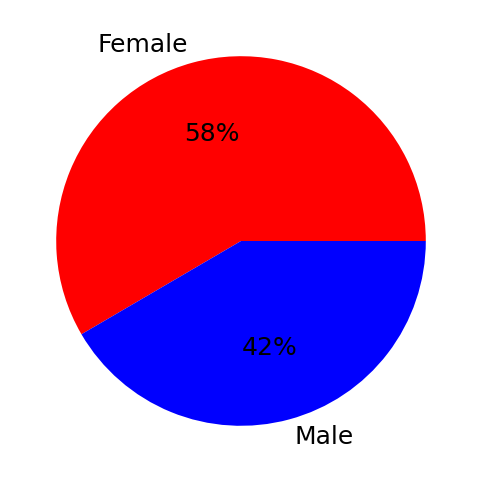

In [ ]:
plt.figure(figsize=[8,6])

plt.pie(x=gender_accident['accident_sex'],labels=gender_accident['victims_sex'],
        colors = ['r','b'],autopct='%.0f%%',textprops={'fontsize': 18})

plt.show()

**2** - Qual faixa etária esteve mais envolvida nos incidentes?

In [ ]:
age_accident = pysqldf("SELECT victims_age, COUNT(injury_result_description) as accident_age FROM df_pd GROUP BY victims_age ORDER BY accident_age DESC LIMIT 1")

In [ ]:
age_accident

,victims_age,accident_age
0,Adult,9623


- Portanto, a faixa etária com maior número de incidentes é a dos *Adultos*.

**3**- Qual o percentual de incidentes por tipo de evento (Incident Event
Type)?

In [ ]:
type_accident = pysqldf("SELECT incident_event_type, COUNT(injury_result_description)* 100.0 / sum(count(*)) over() as accident_type FROM df_pd GROUP BY incident_event_type ORDER BY accident_type DESC")

In [ ]:
type_accident

,incident_event_type,accident_type
0,Slip Trip Fall,31.958689
1,Onboard Injuries,25.769231
2,Personal Injury,19.337607
3,Collision Incident,18.119658
4,Assault,3.490028
5,Activity Incident Event,0.576923
6,Vandalism Hooliganism,0.377493
7,Safety Critical Failure,0.327635
8,Fire,0.021368
9,Robbery,0.021368


### Mostrando os resultados em um gráfico de Barras

<ipython-input-96-edaab72199f5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=type_accident,x='incident_event_type',y='accident_type',palette='CMRmap',aspect=2,size=16)


<Figure size 1200x800 with 0 Axes>

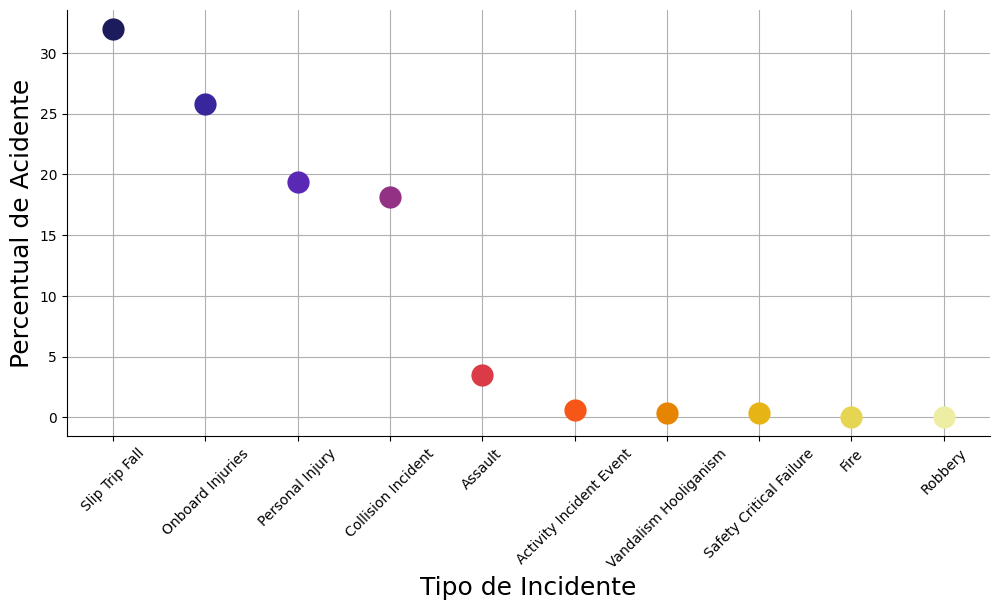

In [ ]:
plt.figure(figsize=[12,8])

sns.catplot(data=type_accident,x='incident_event_type',y='accident_type',palette='CMRmap',aspect=2,size=16)

plt.xticks(rotation=45)
plt.xlabel("Tipo de Incidente", size=18)
plt.ylabel("Percentual de Acidente", size=18)

plt.grid(axis='both')

plt.show()

**4** - Como foi a evolução de incidentes por mês ao longo do tempo?

In [ ]:
time_accident = pysqldf("SELECT year, month, date_of_incident, COUNT(injury_result_description) as accident_date FROM df_pd GROUP BY year, month")

In [ ]:
time_accident.head(5)

,year,month,date_of_incident,accident_date
0,2015.0,1,2015-01-01,211
1,2015.0,2,2015-02-01,198
2,2015.0,3,2015-03-01,244
3,2015.0,4,2015-04-01,294
4,2015.0,5,2015-05-01,260


### Fazendo um gráfico de dispersão

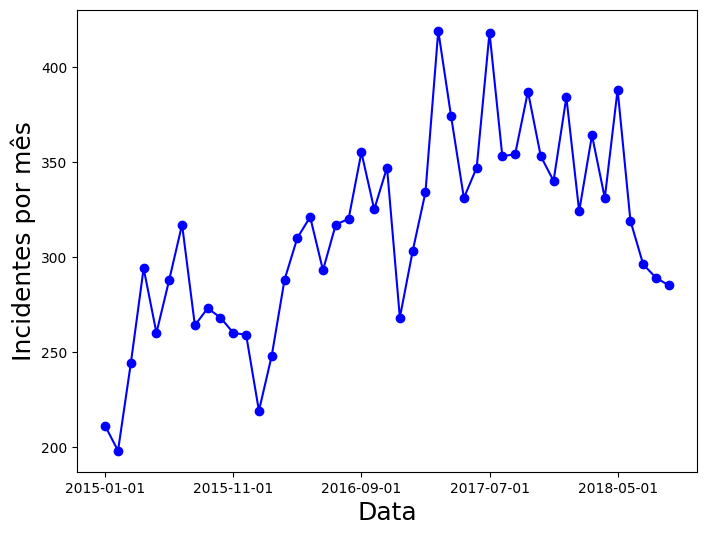

In [ ]:
plt.figure(figsize=[8,6])

time_accident.set_index('date_of_incident')['accident_date'].plot(color='blue',marker='o')
plt.ylabel('Incidentes por mês',size=18)
plt.xlabel('Data',size=18)

plt.show()

**5** - Quando o incidente foi “Collision Incident” em qual mês houve o maior
número de incidentes envolvendo pessoas do sexo feminino?

In [ ]:
collision_accident = pysqldf("SELECT year, month, incident_event_type, victims_sex, COUNT(injury_result_description) as accident_count FROM df_pd \
                            WHERE incident_event_type ='Collision Incident' AND victims_sex = 'Female' ORDER BY accident_count DESC LIMIT 1")

In [ ]:
collision_accident

,year,month,incident_event_type,victims_sex,accident_count
0,2015.0,1,Collision Incident,Female,1072


- Foi no mês de Janeiro de 2015.

**6** - Qual foi a média de incidentes por mês envolvendo crianças (Child)?

In [ ]:
avg_accident = pysqldf("SELECT year, month, victims_age,date_of_incident, COUNT(injury_result_description)/LENGTH(injury_result_description) as media_acc FROM df_pd \
                            WHERE victims_age ='Child' GROUP BY year, month  ")

In [ ]:
avg_accident.head(5)

,year,month,victims_age,date_of_incident,media_acc
0,2015.0,1,Child,2015-01-01,0
1,2015.0,2,Child,2015-02-01,1
2,2015.0,3,Child,2015-03-01,1
3,2015.0,4,Child,2015-04-01,0
4,2015.0,5,Child,2015-05-01,0


### Fazendo uma visualização dos dados acima

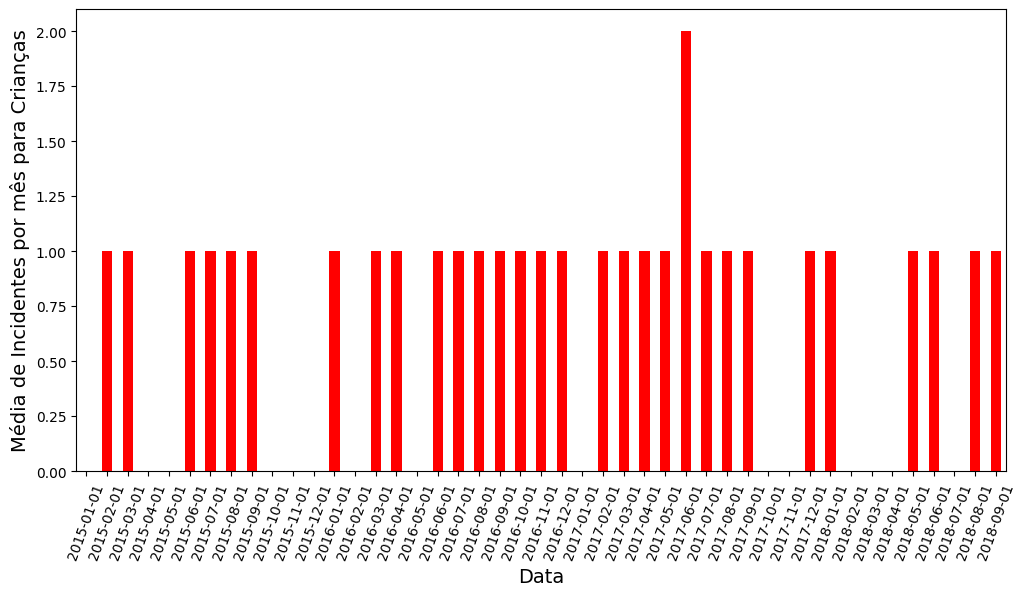

In [ ]:
plt.figure(figsize=[12,6])

avg_accident.set_index('date_of_incident')['media_acc'].plot(kind='bar',color='red')

plt.ylabel('Média de Incidentes por mês para Crianças',size=14)
plt.xlabel('Data',size=14)

plt.xticks(rotation=70)

plt.show()

### Se quisermos a média geral mensal, uma média terá que ser feita em cima desses dados.

In [ ]:
print("A média geral mensal é: {0}".format(np.round(avg_accident['media_acc'].mean(),2)))

A média geral mensal é: 0.69


**7** - Considerando a descrição de incidente como “Injuries treated on scene”
(coluna Injury Result Description), qual o total de incidentes de pessoas
do sexo masculino e sexo feminino?

In [ ]:
sex_accident = pysqldf("SELECT year, month, victims_sex, date_of_incident, COUNT(injury_result_description) as media_sex FROM df_pd \
                      WHERE injury_result_description = 'Injuries treated on scene' GROUP BY victims_sex  ")

In [ ]:
sex_accident

,year,month,victims_sex,date_of_incident,media_sex
0,2015.0,1,Female,2015-01-01,5787
1,2015.0,1,Male,2015-01-01,4086


### Fazendo uma visualização em forma de gráfico de pizza

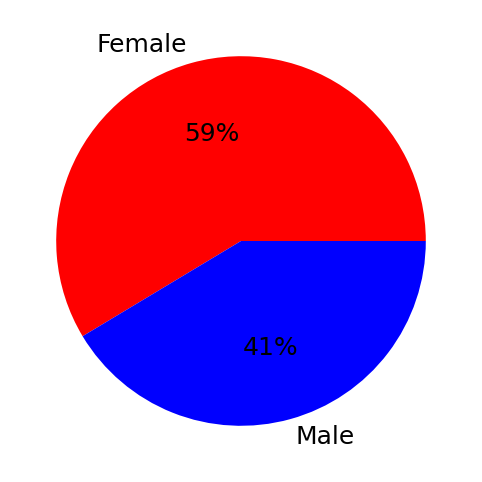

In [ ]:
plt.figure(figsize=[8,6])

plt.pie(x=sex_accident['media_sex'],labels=sex_accident['victims_sex'], colors = ['r','b'],
        autopct='%.0f%%',textprops={'fontsize': 18})

plt.show()

**8** - No ano de 2017, em qual mês houve mais incidentes com idosos
(Elderly)?

In [ ]:
elder_accident = pysqldf("SELECT year, month, victims_age, date_of_incident, COUNT(injury_result_description) AS count_elder FROM df_pd\
                            WHERE year = 2017 AND victims_age = 'Elderly' GROUP BY month  ORDER BY count_elder DESC LIMIT 5")

In [ ]:
elder_accident

,year,month,victims_age,date_of_incident,count_elder
0,2017.0,7,Elderly,2017-07-01,79
1,2017.0,9,Elderly,2017-09-01,75
2,2017.0,4,Elderly,2017-04-01,73
3,2017.0,3,Elderly,2017-03-01,72
4,2017.0,8,Elderly,2017-08-01,67


- Logo, o mês correspondente é **Julho**.

**9** - Considerando o Operador qual a distribuição de incidentes ao longo do
tempo?

In [ ]:
operator_accident = pysqldf("SELECT year, month, operator, date_of_incident, COUNT(injury_result_description) AS count_operator FROM df_pd\
                           GROUP BY operator, month ORDER BY date_of_incident ")

In [ ]:
operator_accident.head(5)

,year,month,operator,date_of_incident,count_operator
0,2015.0,1,Abellio London,2015-01-01,59
1,2015.0,1,Abellio West,2015-01-01,8
2,2015.0,1,Arriva Kent Thameside,2015-01-01,13
3,2015.0,1,Arriva London North,2015-01-01,63
4,2015.0,1,Arriva London South,2015-01-01,35


### Gráfico de dispersão conveniente para mostrar a evolução dos incidentes por mês para cada categoria de operário

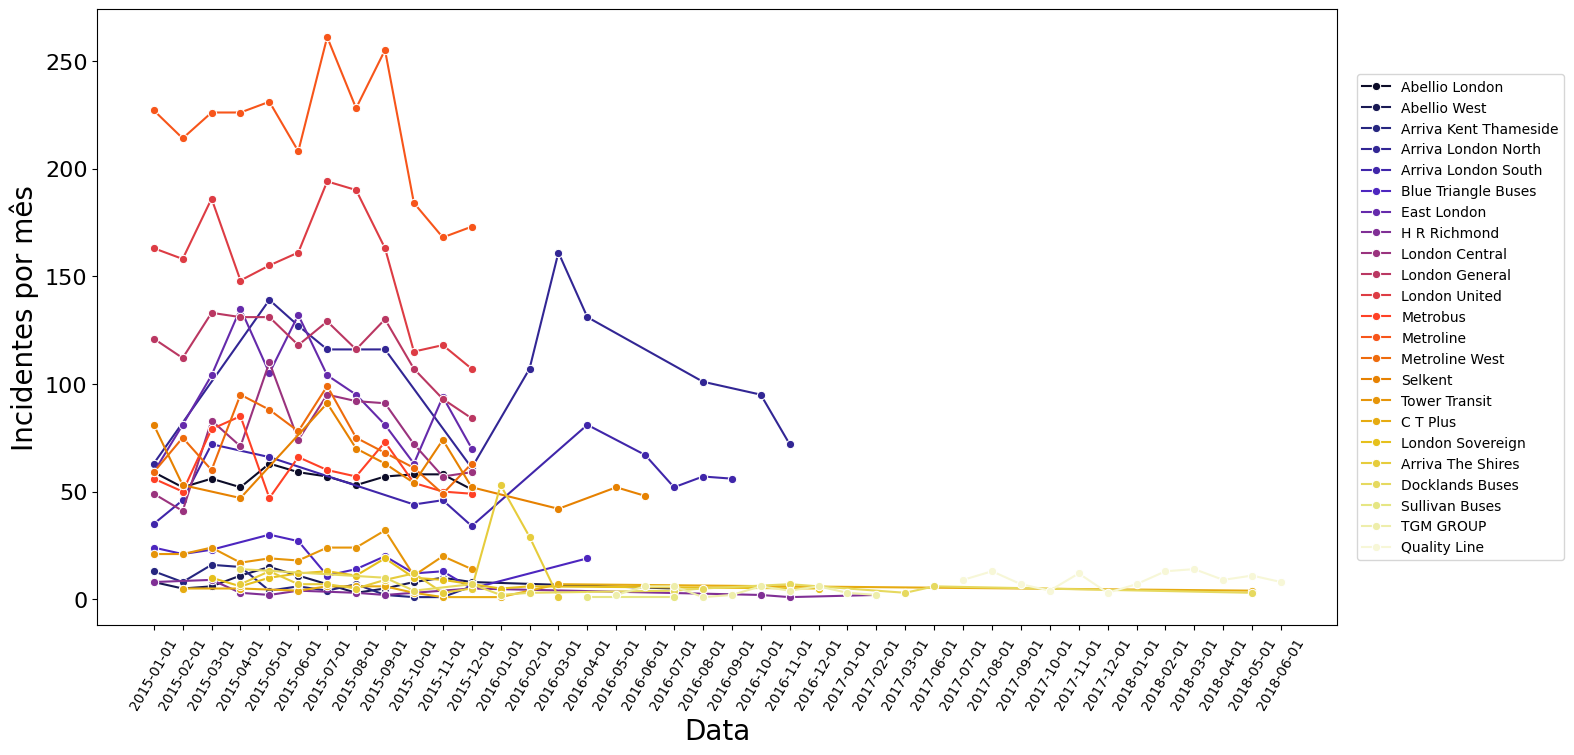

In [ ]:
plt.figure(figsize=[16,8])

sns.lineplot(data=operator_accident, x='date_of_incident',y='count_operator',
            hue='operator',marker='o',palette='CMRmap')

plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)

plt.ylabel('Incidentes por mês',size=20)
plt.xlabel('Data',size=20)

plt.xticks(rotation=60)
plt.yticks(size=16)

plt.show()

- Um pouco difícil de interpretar o gráfico acima, de forma geral. Seria melhor fazer em **plotly**.

**10** - Qual o tipo de incidente mais comum com ciclistas?

In [ ]:
bike_accident = pysqldf("SELECT year, incident_event_type, month, date_of_incident, COUNT(injury_result_description) AS count_bike FROM df_pd\
                       WHERE victim_category = 'Cyclist' GROUP BY incident_event_type ORDER BY count_bike DESC LIMIT 5")

In [ ]:
bike_accident

,year,incident_event_type,month,date_of_incident,count_bike
0,2015.0,Collision Incident,1,2015-01-01,151
1,2016.0,Personal Injury,10,2016-10-01,7
2,2016.0,Slip Trip Fall,12,2016-12-01,5
3,2015.0,Onboard Injuries,7,2015-07-01,3


- Logo, o tipo mais comum de Incidente é o de ***Colisão***.